In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pandas as pd
import os
import json
import csv
import time as t
import math
import numpy as np
from sklearn.metrics import log_loss, roc_auc_score, f1_score, matthews_corrcoef
from sklearn.model_selection import train_test_split
import cv2
from tqdm.notebook import tqdm
import glob
import random
import collections
import gc
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
print(torch.__version__)

with open('adjs.json', 'r') as filehandle:
    adjs = json.load(filehandle)
with open('pnames.json', 'r') as filehandle:
    pnames = json.load(filehandle)
    
GPUS = torch.cuda.device_count()
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

def get_name():
   return  random.sample(adjs, 1)[0] + "_" + random.sample(pnames, 1)[0] 
get_name()

data_dir = '/home/ec2-user/dfdc/dfdc_ds/frames'
img_dir = ''
REAL = 0
FAKE = 1

meta = pd.read_csv(f'{data_dir}/metadata.csv', converters= {
    'label': lambda x: FAKE if x == 'FAKE' else REAL,
    'filename': lambda v: v.replace('.mp4', ''),
    'original': lambda v: v.replace('.mp4', ''),
    'folder': lambda v: int(v.split('_')[-1])
})

print(meta[meta['filename'].isin(['vulukprfvv', 'oebaztypsg'])].index)
meta = meta.drop([79200, 79319])
meta['label'].value_counts()
realOnly = meta[meta['label'] == REAL].sort_values(by='folder')
print(len(realOnly))
allByFolder = meta.groupby('folder')
# allByFolder.count()
# pd.crosstab(meta['folder'], meta['label'], normalize='index').round(4) * 100
#pd.crosstab(meta['folder'], meta['label'])


1.3.1
Int64Index([79200, 79319], dtype='int64')
19154


# HYPER PARAMS

In [2]:
#=======================
SQR_IMG_SIDE = 800

# portrait crop factor
pcf = 0.35
# landscape 
lcf = 0.225
#=======================
ARCH = 'resnext50_32x4d'
# ARCH = 'resnet34'  
# ARCH= 'efficientnet-b0'
# ARCH='mobilenet_v2'
TRAIN_BACK_TO = None
if (GPUS > 1):
    TRAIN_BACK_TO = "module.layer1.0.conv1.weight"
else:
    TRAIN_BACK_TO = "layer1.0.conv1.weight"

DROP_OUT = 0.5
#=======================
VAL_SEED = 99
# 11 folders - I noticed bigger validation set didn't result in better models :(
VAL_FOLDERS = [0, 1, 2, 8, 13, 22, 32, 36, 41, 44, 48]
TEST_FOLDERS = [0,1,2]
ROTATE_FAKES = False
#================================
BATCH_SIZE = 10
EPOCHS = 50
NUM_WORKERS = 16
PIN = False
if GPUS > 1:
  BATCH_SIZE = 10 * GPUS 
  PIN = True
  NUM_WORKERS = 60

# this is 1 because LambdaLR multiplies initial lr with the scheduler function LR
initial_lr = 1
start_lr = 8 * 1e-5
start_lr = 5 * 1e-5

min_lr = 5 * 1e-5
max_lr = 1 * 1e-4
rampup_epochs = 5
sustain_epochs = 1
exp_decay = 0.85 #.95

optimizer_name = 'SGD' 
def get_step_size():
    return 4 * 500 # 220 for batches per epoch  

def get_optimizer(lr, nn):
    if (optimizer_name == 'ADAM'):
        o = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-2) 

    if (optimizer_name == 'SGD'):
        o = torch.optim.SGD(net.parameters(),
                               lr=lr, 
                               weight_decay=1e-3, 
                               nesterov=True,
                               momentum=0.9) # was 99 before resume 
    return o


In [ ]:
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])

In [3]:
def build_dfdc_kaggle_test_df():
    sub_test_df = pd.read_csv(f'/home/ec2-user/dfdc/submission_test.csv', converters= {
        'filename': lambda v: v.replace('.mp4', '')
    })
    sub_data_df = meta[meta['filename'].isin(sub_test_df['filename'])]
    return sub_data_df.sort_values(by='filename')

stdf = build_dfdc_kaggle_test_df()
# print(len(stdf))
# stdf.to_csv('sub_test.csv', index=False)
# sub_test_df = pd.read_csv(f'/home/ec2-user/dfdc/submission_test.csv', converters= {
#     'filename': lambda v: v.replace('.mp4', '')
# }).sort_values(by='filename')
# stdf.count(), "|||", sub_test_df.count()

In [ ]:
# import sklearn
# truth = stdf["label"].to_numpy()
# preds = sub_test_df["label"].to_numpy()
# sklearn.metrics.log_loss(truth, preds)

In [4]:
from torch.utils.data import Dataset
from torchvision.transforms import Normalize
import torchvision.transforms as transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def build_train_sample(size=2500, seed=None):
    trainByFolderAndOriginal = meta[~meta['folder']
                                .isin(VAL_FOLDERS)
                               ].groupby(['folder', 'original'])
    np.random.seed(seed) # change this for new train/val split
    randomized_pairs = trainByFolderAndOriginal.agg(np.random.choice)
    np.random.seed()
    flattened = randomized_pairs.reset_index()
    flattened.head()
    OneFakePerOriginal = flattened.drop(flattened[flattened.original == ''].index)
    OneFakePerOriginal = OneFakePerOriginal.sample(size)
    realOfFake = OneFakePerOriginal['original']
    print(len(OneFakePerOriginal)) # should be equivelant to the # of real videos far above!
    t_fake = OneFakePerOriginal
    t_real = OneFakePerOriginal.copy()
    t_real = t_real.drop(columns=['filename'])
    t_real = t_real.rename(columns={"original":"filename"})
    t_real['label'] = 0
    print(len(t_fake), len(t_real))
    train = pd.concat([t_fake, t_real])
    return train

def build_train_df(seed=None):
    trainByFolderAndOriginal = meta[~meta['folder']
                                    .isin(VAL_FOLDERS)
                                   ].groupby(['folder', 'original'])
    np.random.seed(seed) # change this for new train/val split
    randomized_pairs = trainByFolderAndOriginal.agg(np.random.choice)
    np.random.seed()
    flattened = randomized_pairs.reset_index()
    flattened.head()
    OneFakePerOriginal = flattened.drop(flattened[flattened.original == ''].index)
    print(len(OneFakePerOriginal)) # should be equivelant to the # of real videos far above!
    OneFakePerOriginal.head()
    t_fake = OneFakePerOriginal
    t_real = realOnly[~realOnly['folder'].isin(VAL_FOLDERS)]
    print(len(t_fake), len(t_real))
    train = pd.concat([t_fake, t_real])
    return train
    
def build_val_df(seed=999):
    valByFolderAndOriginal = meta[meta['folder']
                                  .isin(VAL_FOLDERS)].groupby(['folder', 'original'])
    np.random.seed(seed) # change this for new val split
    randomized_pairs = valByFolderAndOriginal.agg(np.random.choice)
    np.random.seed()
    flattened = randomized_pairs.reset_index()
    flattened.head()
    OneFakePerOriginal = flattened.drop(flattened[flattened.original == ''].index)
    print(len(OneFakePerOriginal)) # should be equivelant to the # of real videos far above!
    OneFakePerOriginal.head()
    v_fake = OneFakePerOriginal
    v_real = realOnly[realOnly['folder'].isin(VAL_FOLDERS)]
    print(len(v_fake), len(v_real))
    val = pd.concat([v_fake, v_real])
    return val

def build_test_df(seed=999):
    valByFolderAndOriginal = meta[meta['folder']
                                  .isin(TEST_FOLDERS)].groupby(['folder', 'original'])
    np.random.seed(seed) # change this for new val split
    randomized_pairs = valByFolderAndOriginal.agg(np.random.choice)
    np.random.seed()
    flattened = randomized_pairs.reset_index()
    flattened.head()
    OneFakePerOriginal = flattened.drop(flattened[flattened.original == ''].index)
    print(len(OneFakePerOriginal)) # should be equivelant to the # of real videos far above!
    OneFakePerOriginal.head()
    v_fake = OneFakePerOriginal
    v_real = realOnly[realOnly['folder'].isin(TEST_FOLDERS)]
    print(len(v_fake), len(v_real))
    val = pd.concat([v_fake, v_real])
    return val

class Unnormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        mean = torch.as_tensor(self.mean, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        std = torch.as_tensor(self.std, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        return torch.clamp(tensor * std + mean, 0., 1.)
    
unnormalize_transform = Unnormalize(mean, std)

def crop(img):
    if (img.shape[0] > img.shape[1]):
        img = img[0: int(img.shape[0] - (img.shape[0] * pcf)), :]
    else:
        img = img[:, 0 + int(img.shape[1] * lcf): int(img.shape[1] - img.shape[1] * lcf)]
    return img

def resize_image(img, size):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=cv2.INTER_LANCZOS4)
    return resized

def make_square_image(img, max_size = None):
    h, w = img.shape[:2]
    size = max(h, w) if max_size is None else max_size
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.01):
        self.std = std
        self.mean = mean
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
def load_image_and_label(filename, cls, crops_dir, folder_num, augment):
    """Loads an image into a tensor. Also returns its label."""
    image_size = SQR_IMG_SIDE
    try:
        files = os.listdir(f'{crops_dir}/dfdc_train_part_{str(folder_num)}/{filename}')
        # only randomize frame per video in training set
        if augment:
            np.random.seed()
            p = np.random.choice(np.array(files))
        else:
#             np.random.seed(99)
            p = np.random.choice(np.array(files))
            np.random.seed()
        
        img = cv2.imread(os.path.join(crops_dir, f'dfdc_train_part_{folder_num}', filename, p))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        should_resize = img.shape[0] > image_size or img.shape[1] > image_size
        if should_resize:
            if augment:
                # if portrait
                if (img.shape[0] > img.shape[1]):
                    img = img[0: int(img.shape[0] 
                          - (img.shape[0] * random.uniform(0.30, 0.40))), :]
                else: # landscape
                    img = img[:, int(img.shape[1] * random.uniform(0.20, 0.25)): 
                            int(img.shape[1] - img.shape[1] * random.uniform(0.20, 0.25))]
            else:
                if (img.shape[0] > img.shape[1]):
                    img = img[0: int(img.shape[0] - (img.shape[0] * pcf)), :]
                else: # landscape
                    img = img[:, int(img.shape[1] * lcf): 
                                  int(img.shape[1] -  img.shape[1] * lcf)] 
        
        if should_resize:
            img = resize_image(img, image_size)
        
        if augment: 
            im_pil = Image.fromarray(img)
            train_trans = transforms.Compose([
                transforms.RandomAffine(degrees=(10, -10), 
                                        scale=(0.95, 1.05), 
                                        translate=(0.02, 0.02), 
                                        resample=Image.BICUBIC),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.3, contrast=0, saturation=0, hue=0),
#                 transforms.RandomApply([AddGaussianNoise(0., 0.01)], p = 0.2),
            ])
            img = train_trans(im_pil)
            
        img = np.array(img)
        img = make_square_image(img, image_size)
        generic_trans = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        img = generic_trans(img)
        target = cls
        return img, target
    except:
        print(f'failed to load file: {filename}, folder: {folder_num}')
        raise


class MyDataset(Dataset):
    def __init__(self, crops_dir, df, split, sample_size=None, seed=None):
        self.crops_dir = crops_dir
        self.split = split
        self.df = df
        num_real = len(self.df[self.df["label"] == REAL])
        num_fake = len(self.df[self.df["label"] == FAKE])
        print("%s dataset has %d real videos, %d fake videos" % (split, num_real, num_fake))

    def __getitem__(self, index):
        row = self.df.iloc[index]
        filename = row['filename']
        # if fake, fetch a random faked video (i.e. ignore file name here)
        if (self.split == 'train' 
                and ROTATE_FAKES
                and row['label'] == FAKE):
            sampledFake = meta[meta['original'] == row['original']].sample().iloc[0]
            filename = sampledFake['filename']
            
        cls = row["label"]
        folder_num = row['folder']
        return load_image_and_label(filename, 
                                    cls, 
                                    self.crops_dir, 
                                    folder_num,
                                    self.split == "train")
    def __len__(self):
        return len(self.df)


# Training Loops

In [5]:
def s(x):
    z = 1/(1 + np.exp(-x))
    return z
# try MCC (penalize the bad condident by -1)
# https://stats.stackexchange.com/questions/118219/how-to-interpret-matthews-correlation-coefficient-mcc
def calc_confidence(y_pred, y_true):
    phat = s(y_pred)
    c = np.where(phat < 0.1, 0, phat)
    c = np.where(c > 0.9, 1, c)
    c = np.where(np.logical_and(c != 0, c != 1), 0.5, c)
    r = np.sum(c == y_true)
    return r

def evaluate(net, data_loader, device, silent=True, hist_plot_name=None):
    net.train(False)
    bce_loss = 0
    total_examples = 0
    roc_auc = 0
    yhats = np.array([])
    ys = np.array([])
    confidence = 0
    batches = len(data_loader)
    with tqdm(total=batches, desc="Evaluation", leave=False) as pbar:
        for batch_idx, data in enumerate(data_loader):
            with torch.no_grad():
                batch_size = data[0].shape[0]
                x = data[0].to(device)
                y_true = data[1].to(device).float()
                
                y_pred = net(x)
                y_pred = y_pred.squeeze()
                
                y_pred_np = y_pred.cpu().numpy()
                y_true_np = y_true.cpu().numpy()

                yhats = np.concatenate([yhats, y_pred_np])
                ys = np.concatenate([ys, y_true_np])
                
                bce_loss += F.binary_cross_entropy_with_logits(y_pred, y_true).item()
                confidence += calc_confidence(y_pred_np, y_true_np)
            total_examples += batch_size
            pbar.update()
    
    if (not silent):
        y_hat_df = pd.DataFrame(data=s(yhats), columns=['prediction'])
        ax = y_hat_df.plot.hist(bins=20)
        if not os.path.exists(name):
            os.makedirs(name)
        if (hist_plot_name is None):
            plt.savefig(f'{name}/hist.{epochs_done}.jpg')
        else:
            plt.savefig(f'{name}/{hist_plot_name}.jpg')
    
    probs = s(yhats)
    roc_auc = roc_auc_score(ys, probs)
    pred_cls = np.where(probs > 0.5, 1, 0)
    f1 = f1_score(ys, pred_cls)
    mcc = matthews_corrcoef(ys, pred_cls)
    bce_loss /= batches
    confidence = confidence / total_examples
    return bce_loss, confidence, roc_auc, f1, mcc

fieldnames = ['epoch', 'batch_size', 'lr', 'tloss', 
              'vloss', 'confidence', 'roc_acc', 'f1', 'mcc', 'optimizer' ]

def init_log():
     with open(f'{name}_{GPUS}xGPU_{ARCH}.csv', 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
def log_epoch(data):
    with open(f'{name}_{GPUS}xGPU_{ARCH}.csv', 'a') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if (data is not None):
            writer.writerow(data)

def fit(epochs, cp=True, log=True):
    global history, iteration, epochs_done, lr

    with tqdm(total=len(tdl), leave=False) as pbar:
        for epoch in range(epochs):
            pbar.reset()
            pbar.set_description("Epoch %d" % (epochs_done + 1))
            bce_loss = 0
            total_examples = 0
            net.train(True)
            for batch_idx, data in enumerate(tdl):
                batch_size = data[0].shape[0]
                x = data[0].to(gpu)
                y_true = data[1].to(gpu).float()
                optimizer.zero_grad()
                y_pred = net(x)
                y_pred = y_pred.squeeze()
                
                loss = F.binary_cross_entropy_with_logits(y_pred, y_true)
                loss.backward()
                optimizer.step()
                
                batch_bce = loss.item()
                bce_loss += batch_bce * batch_size
                history["train_bce"].append(batch_bce)
                total_examples += batch_size
                iloss = round(bce_loss / total_examples, 4)
                pbar.set_description(f"Epoch {epochs_done + 1} (loss:{iloss}) ")
                iteration += 1
                pbar.update()
                if (is_batch_lr_scheduler and lr_scheduler is not None):
                    lr_scheduler.step()
            bce_loss /= total_examples
            epochs_done += 1
            
            print("Epoch: %3d, train BCE: %.4f" % (epochs_done, bce_loss))

            val_bce_loss, confidence, roc_acc, f1, mcc = evaluate(net, vdl, device=gpu, silent=False)
            history["val_bce"].append(val_bce_loss)
            history["confidence"].append(confidence)
            print(f"    val BCE: {val_bce_loss}, confidence: {confidence}, roc_acc: {roc_acc}, f1: {f1}, mcc: {mcc}")
            
            if (log):                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
                log_epoch({
                    'epoch': epochs_done,
                    'batch_size': BATCH_SIZE,
                    'lr': lr_scheduler.get_lr() if lr_scheduler is not None else start_lr,
                    'tloss': round(bce_loss, 6),
                    'vloss': round(val_bce_loss, 6),
                    'confidence': round(confidence,6),
                    'roc_acc': round(roc_acc, 6),
                    'f1': round(f1, 6),
                    'mcc': round(mcc, 6),
                    'optimizer': optimizer_name,
                })
                
            if (not is_batch_lr_scheduler and lr_scheduler is not None):
                    lr_scheduler.step()

            # save the last epoch checkpoint
            if hasattr(net, 'module'):
                model_state = net.module.state_dict()
            else:
                model_state = net.state_dict()
            torch.save({
                'epoch': epochs_done,
                'model_state_dict': model_state,
                'loss': val_bce_loss,
                'confidence': confidence,
                }, f"{name}.last.ckpt.pth")
            # save the best checkpoint aside 
            if (should_save(cp, history, confidence, val_bce_loss)):
                if hasattr(net, 'module'):
                    model_state = net.module.state_dict()
                else:
                    model_state = net.state_dict()
                torch.save({
                    'epoch': epochs_done,
                    'model_state_dict': model_state,
#                   'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_bce_loss,
                    'confidence': confidence,
                    }, f"{name}.ckpt.pth")
                print(f'saved: {name}.ckpt.pth')
            print('-----------------------------------------------')
            
def should_save(cp, history, confidence, val_loss):
    return cp == True and len(history['val_bce']) \
            and val_loss <= np.min(np.array(history['val_bce']))
        
#          and (len(history['confidence']) == 0 
#          or (
#              confidence >= np.max(np.array(history['confidence']))
#              and
#              val_loss <= np.min(np.array(history['val_bce']))
#             )
#         )# 
               

# Model 

In [6]:
import torchvision.models as models
import torch.nn as nn

##Load new model
def get_model(pretrained = True):
    model = torch.hub.load('pytorch/vision:v0.5.0', ARCH, pretrained)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(DROP_OUT),
        nn.Linear(num_ftrs, 1)
    )
    return model

def freeze_until(net, param_name):
    if (param_name == None):
        model.train(True)
        return
    found_name = False
    for name, params in net.named_parameters():
        if name == param_name:
            found_name = True
        params.requires_grad = found_name
        
def load_model_from_checkpoint(file_name):
    model = get_model(False)
    checkpoint = torch.load(file_name)
    model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    conf = checkpoint['confidence']
    return model, epoch, loss, conf



# Training Data loader Parameters

In [8]:
train = build_train_df() #build_train_sample(size=FAKE_TRAIN_SIZE)
val = build_val_df(VAL_SEED)
test = build_test_df()
val.head()

val_len = len(val)
train_len = len(train)
print(train_len, val_len, len(test))

15455
15455 15455
3699
3699 3699
424
424 424
30910 7398 848


In [ ]:
train.head()

In [ ]:
def display_image_in_actual_size(tensor):
    dpi = 80
    height, width, depth = tensor.size()

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
#     ax.axis('off')

    # Display the image.
    ax.imshow(tensor)

    plt.show()

In [ ]:
%%time
r = train.sample().values[0]
print(r)
augment = True
img_tensor, label = load_image_and_label(r[0], 1, data_dir, r[1], augment)
display_image_in_actual_size(unnormalize_transform(img_tensor).permute(1, 2, 0))

In [ ]:
r = train.sample().values[0]
print(r)
augment = False
img_tensor, label = load_image_and_label(r[0], 1, data_dir, r[1], augment)
display_image_in_actual_size(unnormalize_transform(img_tensor).permute(1, 2, 0))

In [9]:
train_ds = MyDataset(data_dir, train, 'train')
val_ds = MyDataset(data_dir, val, 'val')
test_ds = MyDataset(data_dir, stdf, 'test')

train dataset has 15455 real videos, 15455 fake videos
val dataset has 3699 real videos, 3699 fake videos
test dataset has 200 real videos, 200 fake videos


In [10]:
def create_data_loaders():
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, 
                              num_workers=NUM_WORKERS, pin_memory=PIN)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, 
                            num_workers=NUM_WORKERS, pin_memory=PIN)

    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, 
                            num_workers=NUM_WORKERS, pin_memory=PIN)
    
    return train_loader, val_loader, test_loader

tdl, vdl, testdl = create_data_loaders()

# vit = iter(vdl)
# X, y = next(vit)
# plt.imshow(unnormalize_transform(X[0]).permute(1, 2, 0))
# del vit

In [ ]:
# for batch_idx, data in enumerate(tdl):
#     print(batch_idx)
#     print(data[0].shape[0], data[1].shape[0])
#     break

In [ ]:
# len(tdl)

In [ ]:
x, y = train_ds.__getitem__(88)
plt.imshow(unnormalize_transform(x).permute(1, 2, 0))

# Training 

In [11]:
# Resume
# safety gaurd 
load_existing = True
if load_existing:
    name = "risque_Espeon"
    model, epochss, loss, conf = load_model_from_checkpoint(f"{name}.ckpt.pth")
    epochs_done = epochss
    # filled from logs
    history = { "train_bce": [], "val_bce": [loss], "confidence": [conf] } 
    print(f'loaded, {history}')
else:
    # NEW
    name = get_name()
    init_log()
    print(name)
    # Load new Model
    model = get_model(True)
    history = { "train_bce": [], "val_bce": [], "confidence": [] }
    epochs_done = 0

if GPUS > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)
net = model.to(gpu)



Using cache found in /home/ec2-user/.cache/torch/hub/pytorch_vision_v0.5.0


loaded, {'train_bce': [], 'val_bce': [0.2196555838290904], 'confidence': [0.7675047310083807]}


In [ ]:
net

In [12]:
net.train(True)
iteration = 0
freeze_until(net, TRAIN_BACK_TO)
[k for k,v in net.named_parameters() if v.requires_grad]

['layer1.0.conv1.weight',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.conv2.weight',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.0.conv3.weight',
 'layer1.0.bn3.weight',
 'layer1.0.bn3.bias',
 'layer1.0.downsample.0.weight',
 'layer1.0.downsample.1.weight',
 'layer1.0.downsample.1.bias',
 'layer1.1.conv1.weight',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.conv2.weight',
 'layer1.1.bn2.weight',
 'layer1.1.bn2.bias',
 'layer1.1.conv3.weight',
 'layer1.1.bn3.weight',
 'layer1.1.bn3.bias',
 'layer1.2.conv1.weight',
 'layer1.2.bn1.weight',
 'layer1.2.bn1.bias',
 'layer1.2.conv2.weight',
 'layer1.2.bn2.weight',
 'layer1.2.bn2.bias',
 'layer1.2.conv3.weight',
 'layer1.2.bn3.weight',
 'layer1.2.bn3.bias',
 'layer2.0.conv1.weight',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias',
 'layer2.0.conv2.weight',
 'layer2.0.bn2.weight',
 'layer2.0.bn2.bias',
 'layer2.0.conv3.weight',
 'layer2.0.bn3.weight',
 'layer2.0.bn3.bias',
 'layer2.0.downsample.0.weight',
 'laye

## Optimizer And LR scheduler

$$f\left(x,\ l_{0},\ l_{1},\ b\right)\ =l_{0}\ +\ \ \left(l_{1}\ -\ l_{0}\right)\ \cdot\ b^{\left(x-1\right)}$$

In [13]:
# whether to step the lr scheduler each batch vs epoch
is_batch_lr_scheduler = False
use_lr_scheduler = 'exp_one_cycle' # or None for no schedule
use_lr_scheduler = None
lr_scheduler = None
if (use_lr_scheduler is None):
    optimizer = get_optimizer(start_lr, net)
if (use_lr_scheduler == 'cyclic_lr'):
    optimizer = get_optimizer(start_lr, net)
    lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                             start_lr, 
                                             end_lr, 
                                             cycle_momentum=False, 
                                             step_size_up = get_step_size())
if (use_lr_scheduler == 'exp_one_cycle'):
    optimizer = get_optimizer(1, net)
    lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, 
                                             lrfn, 
                                             last_epoch=-1)

In [14]:
optimizer, lr_scheduler, epochs_done

(SGD (
 Parameter Group 0
     dampening: 0
     lr: 5e-05
     momentum: 0.9
     nesterov: True
     weight_decay: 0.001
 ), None, 16)

In [15]:
name

'risque_Espeon'

Epoch:  17, train BCE: 0.1074


    val BCE: 0.3276357426509266, confidence: 0.7233035955663693, roc_acc: 0.9768679946159359, f1: 0.8856651094172608, mcc: 0.763853930921804
-----------------------------------------------
Epoch:  18, train BCE: 0.0968


    val BCE: 0.2753676272906002, confidence: 0.7703433360367667, roc_acc: 0.976736440681125, f1: 0.9048830111902341, mcc: 0.8041903442687932
-----------------------------------------------
Epoch:  19, train BCE: 0.0947


    val BCE: 0.23857712913098086, confidence: 0.7731819410651527, roc_acc: 0.9787017102961637, f1: 0.9133838059797253, mcc: 0.8222196437328272
-----------------------------------------------
Epoch:  20, train BCE: 0.0915


    val BCE: 0.22959544612959026, confidence: 0.785617734522844, roc_acc: 0.9794786093667425, f1: 0.917680559150919, mcc: 0.8313364177522237
-----------------------------------------------
Epoch:  21, train BCE: 0.0895


    val BCE: 0.22441581004666758, confidence: 0.7816977561503109, roc_acc: 0.9822529356808695, f1: 0.9200359389038635, mcc: 0.836309622936252
-----------------------------------------------
Epoch:  22, train BCE: 0.0880


    val BCE: 0.29358398537966374, confidence: 0.7734522844011895, roc_acc: 0.9785250625959202, f1: 0.9025524959134917, mcc: 0.7995347733482562
-----------------------------------------------
Epoch:  23, train BCE: 0.0853


    val BCE: 0.32170429697896025, confidence: 0.7600702892673695, roc_acc: 0.9790504013089323, f1: 0.8929368029739777, mcc: 0.7793929077236448
-----------------------------------------------
Epoch:  24, train BCE: 0.0836


    val BCE: 0.32594010525445394, confidence: 0.7534468775344688, roc_acc: 0.9788948022382586, f1: 0.8880128126154984, mcc: 0.7689236440536399
-----------------------------------------------
Epoch:  25, train BCE: 0.0859


    val BCE: 0.3105500671163542, confidence: 0.7721005677210057, roc_acc: 0.978039994004064, f1: 0.8981527708437345, mcc: 0.790364325068241
-----------------------------------------------
Epoch:  26, train BCE: 0.0816


    val BCE: 0.35148169259542505, confidence: 0.7627737226277372, roc_acc: 0.9744209452574113, f1: 0.8892746435213886, mcc: 0.7712251834938099
-----------------------------------------------
Epoch:  27, train BCE: 0.0810


failed to load file: yxiorfqcnp, folder: 41
failed to load file: crsfsmblkf, folder: 41
failed to load file: rvgedehoeg, folder: 41


KeyboardInterrupt: 

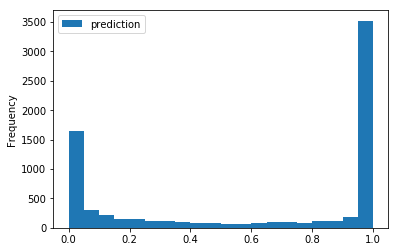

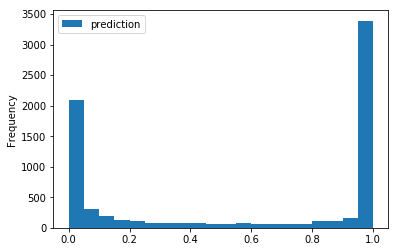

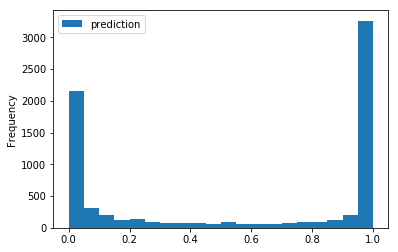

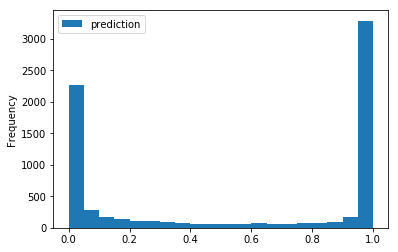

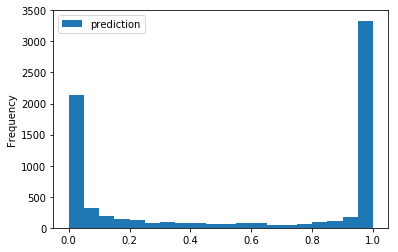

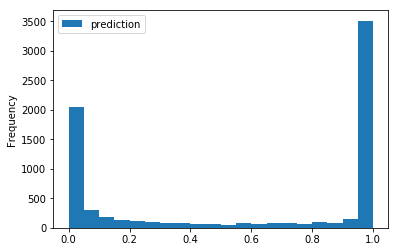

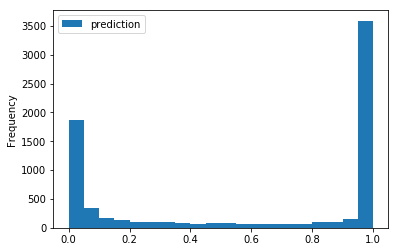

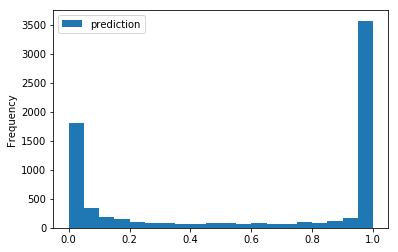

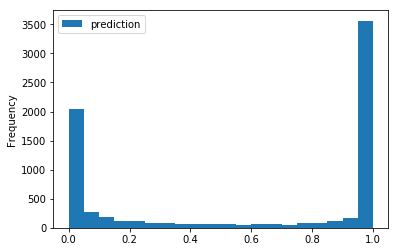

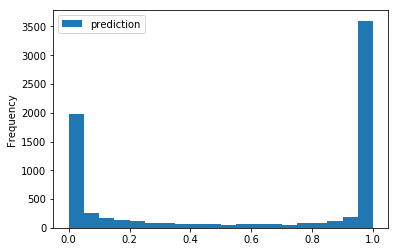

In [16]:
# epochs done is subtracted in case of interruption
fit(EPOCHS - epochs_done)

# LR Finder

https://towardsdatascience.com/adaptive-and-cyclical-learning-rates-using-pytorch-2bf904d18dee

https://github.com/TDehaene/blogposts/blob/master/learning_rates/notebooks/Model%20training.ipynb


In [ ]:
model = get_model(True)
if GPUS > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)
tnet = model.to(gpu)
tnet

In [ ]:
freeze_until(tnet, TRAIN_BACK_TO)
START_LR = 1e-7
END_LR = 0.1
SMOOTHING_LR_LOSS = 0.05
LR_FIND_EPOCHS = 2
lr_lambda = lambda x: math.exp(x * math.log(END_LR / START_LR) / (LR_FIND_EPOCHS * len(tdl)))
optimizer = get_optimizer(START_L                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         R, tnet)
find_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
def lr_finder(epochs, cp=True, log=True):
    lr_history = { "train_bce": [],"lr_loss": [], "lr_steps": [] }
    iteration = 0
    epochs_done = 0
    with tqdm(total=len(tdl), leave=False) as pbar:
        for epoch in range(epochs):
            pbar.reset()
            pbar.set_description("Epoch %d" % (epochs_done + 1))
            bce_loss = 0
            total_examples = 0
            tnet.train(True)
            for batch_idx, data in enumerate(tdl):
                batch_size = data[0].shape[0]
                x = data[0].to(gpu)
                y_true = data[1].to(gpu).float()
                optimizer.zero_grad()
                y_pred = tnet(x)
                y_pred = y_pred.squeeze()
                loss = F.binary_cross_entropy_with_logits(y_pred, y_true)
                loss.backward()
                optimizer.step()
                batch_bce = loss.item()
                bce_loss += batch_bce * batch_size
                lr_history["train_bce"].append(batch_bce)
                total_examples += batch_size
                iloss = round(bce_loss / total_examples, 4)
                pbar.set_description(f"Epoch {epochs_done + 1} (loss:{iloss}) ")
                
                ## LR scheduler
                find_lr_scheduler.step()
                lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                lr_history["lr_steps"].append(lr_step)

                # smooth the loss
                if iteration == 0:
                  lr_history["lr_loss"].append(batch_bce)
                else:
                  lr_loss = SMOOTHING_LR_LOSS  * batch_bce \
                        + (1 - SMOOTHING_LR_LOSS) * lr_history["lr_loss"][-1]
                  lr_history["lr_loss"].append(lr_loss)
        
                iteration += 1
                pbar.update()

            bce_loss /= total_examples
            epochs_done += 1
            print("Epoch: %3d, train BCE: %.4f" % (epochs_done, bce_loss))

    return lr_history

In [ ]:
h = lr_finder(LR_FIND_EPOCHS)
del tnet
del optimizer

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.ylabel("loss")
plt.xlabel("lr")
plt.xscale("log")
plt.plot(h["lr_steps"], h["lr_loss"])
plt.show()

In [ ]:
lr_max = 2 * (10 ** -2) / 10
lr_max

In [ ]:
lr_min = round(lr_max / 6, 7)
lr_min 

In [ ]:
LR = 9e-5
LR

# Metrics

In [ ]:
# name = 'inattentive_Jangmo-o'
epochs_done

In [19]:
model, epoch, loss, conf = load_model_from_checkpoint("risque_Espeon.e20.ckpt.pth")
print(epoch, loss, conf)
if GPUS > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)
net = model.to(gpu)

Using cache found in /home/ec2-user/.cache/torch/hub/pytorch_vision_v0.5.0


20 0.22959544612959026 0.785617734522844


In [ ]:
print(epoch, loss, conf)

In [ ]:
plt.plot(history["train_bce"])

In [ ]:
plt.plot(history["val_bce"])
plt.grid(True)

In [ ]:
plt.plot(history["confidence"])
plt.grid(True)

(0.23933461228174369,
 0.7881859962151933,
 0.9782475568789881,
 0.9125661888157045,
 0.8205543599444584)

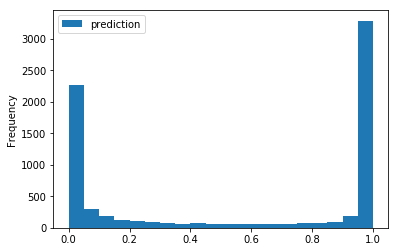

In [21]:
metrics = evaluate(net, vdl, device=gpu, silent=False, hist_plot_name='temp_eval')
metrics

(0.2955771998385899, 0.7, 0.954275, 0.873170731707317, 0.7409267379962031)

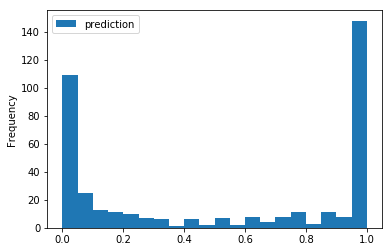

In [20]:
tmetrics = evaluate(net, testdl, device=gpu, silent=False, hist_plot_name='temp_eval')
tmetrics

# Export 

In [22]:
def export():
    torch.save(net, f"{name}.e{epoch}.all.pth")
    print('saved model')
export()


saved model


In [ ]:
import gc
try:
    del net
    del tdl
    del vdl
    del optimizer
except:
    pass
torch.cuda.empty_cache()
gc.collect() 


In [ ]:
import json
with open('adjs.json', 'w') as filehandle:
    json.dump(adjs, filehandle)
with open('pnames.json', 'w') as filehandle:
    json.dump(pnames, filehandle)

In [ ]:
with open('adjs.json', 'r') as filehandle:
    adx = json.load(filehandle)
print(adx)

# Experiments log

https://docs.google.com/spreadsheets/d/1lfKEGH5-cUc8vP3E7b3l6FSzUVimPj-6c9ZEgVWJ96o/edit?usp=sharing